## Variance Decompositions
Variance decomposition results for sections 5 and 6 of the paper.

#### Config

In [1]:
## load some packages
# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc
import seaborn as sns
import pandas as pd
import numpy as np
import cmcrameri

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'figure.titlesize': 'medium',
        'figure.labelsize': 'medium',
        'axes.titlesize': 'medium',
    })
cmap = 'cmc.batlow'
sns.set_palette(sns.color_palette(cmap, n_colors=7))
save = True

#### Solve the Model

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 500
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 3.1554601309064183; beta = 0.944885031287334'

#### Estimates
Plug in the estimates we found earlier

In [3]:
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

#### Variance Decomposition (Aggs)

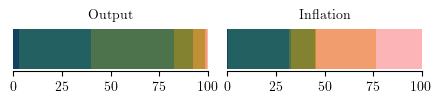

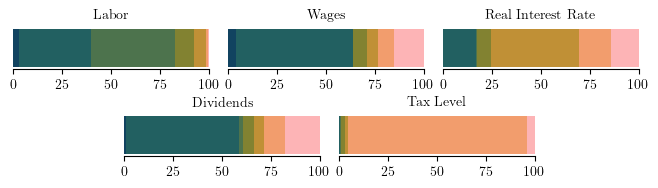

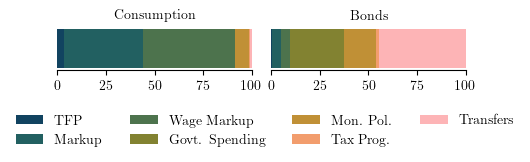

In [4]:
## get variaences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas), h=4)
# labels = {   # keys for labeling
#         'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
#         'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
#         'curlC': '$C$', 'curlB': '$B$',  # hh aggs
#         'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$', 'L': '$L$',  # econ aggs
#     }
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending', 'L': 'Labor',  # econ aggs
    }

def plot_var_decomp(var, ax):
    # format graph
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, 100)

    # varience decompoisiont
    shock_pct = np.array(list(var.values()))
    shock_pct = 100 * shock_pct / shock_pct.sum()
    shock_pct_start = shock_pct.cumsum() - shock_pct
    for i, s in enumerate(var.keys()):
        ax.barh('h', shock_pct[i], left=shock_pct_start[i], label=labels[s])

## make the plots
for outcomes, t in zip([['Y', 'pi'], ['L', 'W', 'R', 'D', 'tauL'], ['curlC', 'curlB']], ['agg', 'hh_dec', 'hh_agg']):
    w = min(len(outcomes), 3)
    h = -(-len(outcomes) // 3)
    fig, axs = plt.subplots(h, w)
    fig.set_figwidth(6.5 / 3 * w)
    fig.set_figheight(0.1 + 0.85 * h)
    for i, X in enumerate(outcomes):
        axs.take(i).set_title(labels[X])
        plot_var_decomp(vars[X], axs.take(i))
    n_empty = w * h - len(outcomes)
    for i in range(n_empty):
        axs[-1, -1 - i].axis('off')
    fig.tight_layout(pad=0.4)
    if n_empty > 0:
        xs = 0.5 - (axs[-1, 0].get_position().x0 + axs[-1, w - n_empty - 1].get_position().x1) / 2
        for i in range(w - n_empty):
            (x0, y0), (x1, y1) = axs[-1, i].get_position().get_points()
            axs[-1, i].set_position([x0 + xs, y0, x1 - x0, y1 - y0])
    if save: fig.savefig('paper/figures/var_decomp_' + t + '.pgf')
fig.set_figheight(0.7 + 0.85 * h)
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=4/7)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/var_decomp_' + t + '.pgf', bbox_inches='tight')

### IRFs
IRFs for each of the shocks. These go in the appendix.

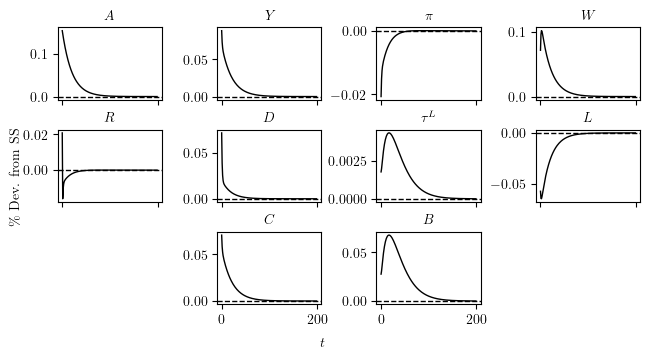

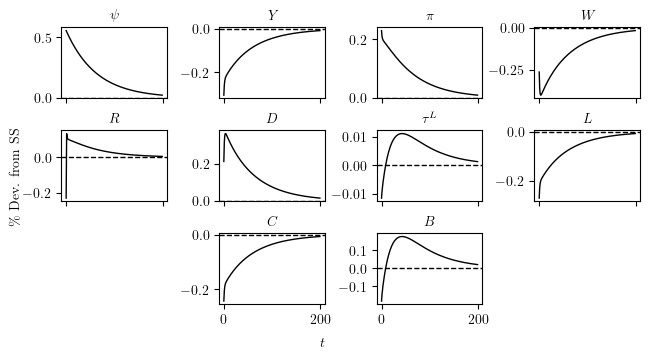

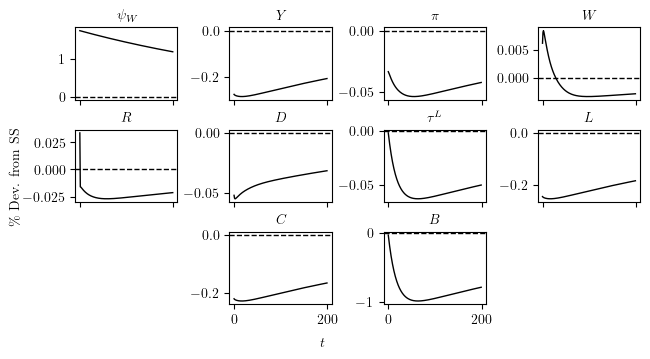

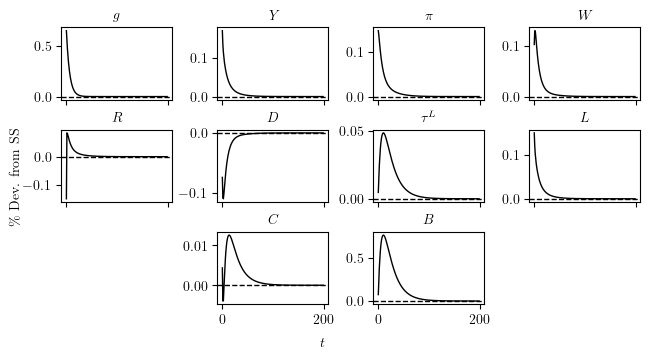

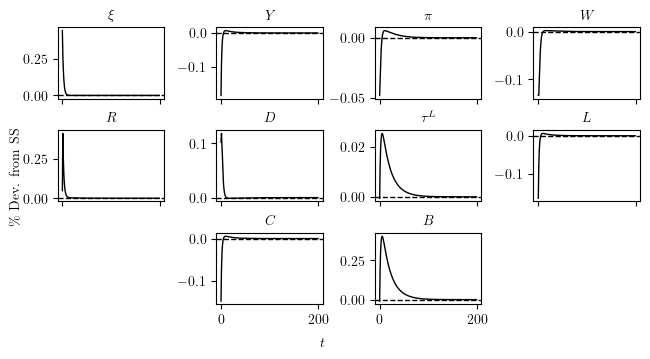

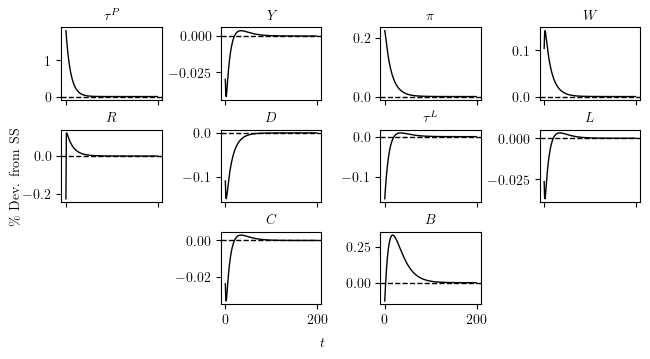

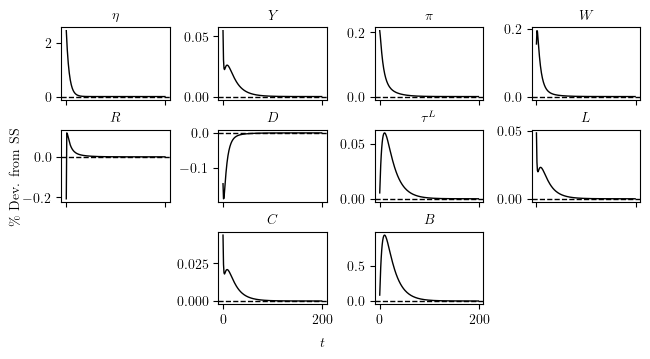

In [5]:
tmax = 200
labels = {   # keys for labeling
        'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$', 'L': '$L$',  # econ aggs
    }

for Z in hank.shocks:
    # solve irfs
    X_irfs, Z_irf = single_shock_irfs(G[Z], rhos[Z], T, sigma=sigmas[Z])

    # plot setup
    fig, axs = plt.subplots(3, 4, sharex=True)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supxlabel('$t$')
    fig.supylabel(r'\% Dev. from SS')
    axs[2, 0].set_axis_off()
    axs[2, 3].set_axis_off()
    axs = np.delete(axs.flatten(), [8, 11])
    outcomes = ['Y', 'pi', 'W', 'R', 'D', 'tauL', 'L', 'curlC', 'curlB']

    # plot each irf
    axs[0].set_title(labels[Z])
    axs[0].plot(Z_irf[:tmax], '-k', linewidth=1)
    axs[0].axhline(0, c='k', ls='--', linewidth=1)
    for ax, X in zip(axs[1:], outcomes):
        ax.set_title(labels[X])
        ax.plot(X_irfs[X][:tmax], '-k', linewidth=1)
        ax.axhline(0, c='k', ls='--', linewidth=1)

    # final things
    fig.tight_layout(pad=0.5)
    if save: fig.savefig(f'paper/figures/{Z[3:]}_agg_irf.pgf')

#### HH Steady States
Table of information about household steady states.

In [6]:
## Areas of interest
wealth_percentiles = [0, 0.5, 0.9, 0.99]
income_percentiles = [0.1, 0.5, 0.9]
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), wealth_percentiles)  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), income_percentiles)  # points on the productivity grid, 10th, 50th, 90th percentile
hank.z_grid[pts_z], hank.a_grid[pts_a]

# make info
hh_df = pd.DataFrame(
        np.array([
            np.repeat(hank.z_grid[pts_z], len(wealth_percentiles)),
            np.tile(hank.a_grid[pts_a], (len(income_percentiles), 1)).ravel(),
            hank.c[pts_a][:, pts_z].T.ravel(),
            hank.a[pts_a][:, pts_z].T.ravel(),
        ]).T,
        columns=['z', 'wealth', 'c', 'a']
    )
hh_df['W'] = hh_df['z'] * hank.L * hank.W
hh_df['W_share'] = hh_df['W']
hh_df['R'] = hh_df['wealth'] * hank.R
hh_df['R_share'] = hh_df['R']
hh_df['T'] = hank.D + hank.eta
hh_df['T_share'] = hh_df['T'] 
hh_df['tau'] = -hank.tauL * hh_df['z']**hank.tauP
hh_df['tau_share'] = hank.tauL * hh_df['z']**hank.tauP
hh_df['total'] = hh_df['W'] + hh_df['R'] + hh_df['T'] + hh_df['tau']
hh_df['total_share'] = hh_df['total']
hh_df[['W_share', 'R_share', 'T_share', 'tau_share', 'total_share']] = hh_df[['W_share', 'R_share', 'T_share', 'tau_share', 'total_share']].div(hh_df['total'].values, axis=0) * 100

hh_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
z,0.443992,0.443992,0.443992,0.443992,1.000000,1.000000,1.000000,1.000000,2.252291,2.252291,2.252291,2.252291
wealth,0.000000,0.039830,1.874048,5.896041,0.000000,0.039830,1.874048,5.896041,0.000000,0.039830,1.874048,5.896041
c,0.482757,0.506732,0.696254,0.896486,0.744493,0.754108,0.897784,1.078968,1.108667,1.111029,1.200052,1.351746
a,0.000000,0.016053,1.669921,5.511791,0.000000,0.030414,1.730127,5.591045,0.172849,0.210516,1.964882,5.855292
W,0.327247,0.327247,0.327247,0.327247,0.737055,0.737055,0.737055,0.737055,1.660062,1.660062,1.660062,1.660062
W_share,67.787113,62.596760,13.830201,5.106625,99.000906,93.949558,28.047173,11.050274,129.538858,125.615200,52.451693,23.033901
R,0.000000,0.040029,1.883418,5.925521,0.000000,0.040029,1.883418,5.925521,0.000000,0.040029,1.883418,5.925521
R_share,0.000000,7.656843,79.597596,92.466672,0.000000,5.102325,71.669782,88.838209,0.000000,3.028943,59.508912,82.218539
T,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667,0.247667
T_share,51.302602,47.374443,10.466964,3.864793,33.266487,31.569123,9.424469,3.713136,19.326061,18.740686,7.825332,3.436456


#### HH Decision Rules
Appendix

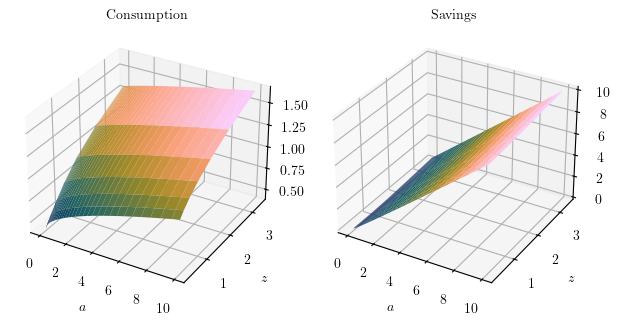

In [7]:
## plot setup
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(3.5)
for ax in axs:
    ax.set_xlabel('$a$')
    ax.set_ylabel('$z$')

## plot each thing
n = (hank.a_grid <= 10).sum()
axs[0].set_title('Consumption')
axs[0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.c[:n], cmap=cmap)
axs[1].set_title('Savings')
axs[1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.a[:n], cmap=cmap)

# final things
fig.tight_layout(pad=2.5)
if save: fig.savefig('paper/figures/policy_rule_surface.pgf')

#### HH Income

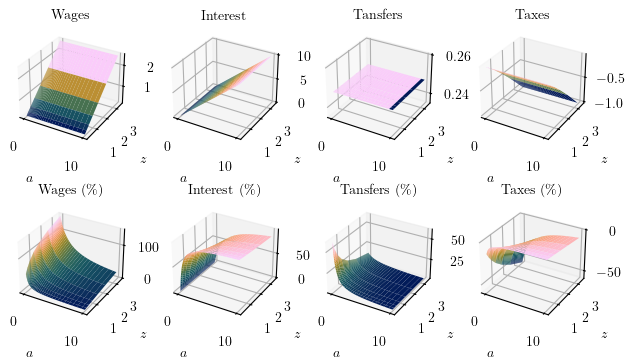

In [8]:
## get elements
n = (hank.a_grid <= 10).sum()
W_act = hank.z_grid * hank.L * hank.W
R_act = (hank.a_grid[:n] * hank.R)[:, None]
T_act = hank.D + hank.eta
tau_act = -hank.tauL * hank.z_grid**hank.tauP
total = W_act + R_act + T_act + tau_act
W_pct = 100 * W_act / total
R_pct = 100 * R_act / total
T_pct = 100 * T_act / total
tau_pct = 100 * tau_act / total

## plot it
fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(4)
for ax in axs.ravel():
    ax.set_xlabel('$a$')
    ax.set_ylabel('$z$')

## plot each thing
axs[0, 0].set_title(r'Wages')
axs[0, 0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=W_act + total * 0, cmap=cmap)
axs[0, 1].set_title(r'Interest')
axs[0, 1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=R_act + total * 0, cmap=cmap)
axs[0, 2].set_title(r'Tansfers')
axs[0, 2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=T_act + total * 0, cmap=cmap)
axs[0, 3].set_title(r'Taxes')
axs[0, 3].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=tau_act + total * 0, cmap=cmap)

axs[1, 0].set_title(r'Wages (\%)')
axs[1, 0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=W_pct, cmap=cmap)
axs[1, 1].set_title(r'Interest (\%)')
axs[1, 1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=R_pct, cmap=cmap)
axs[1, 2].set_title(r'Tansfers (\%)')
axs[1, 2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=T_pct, cmap=cmap)
axs[1, 3].set_title(r'Taxes (\%)')
axs[1, 3].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=tau_pct, cmap=cmap)

# final things
fig.tight_layout(pad=2.5)
if save: fig.savefig('paper/figures/hh_income_surface.pgf')

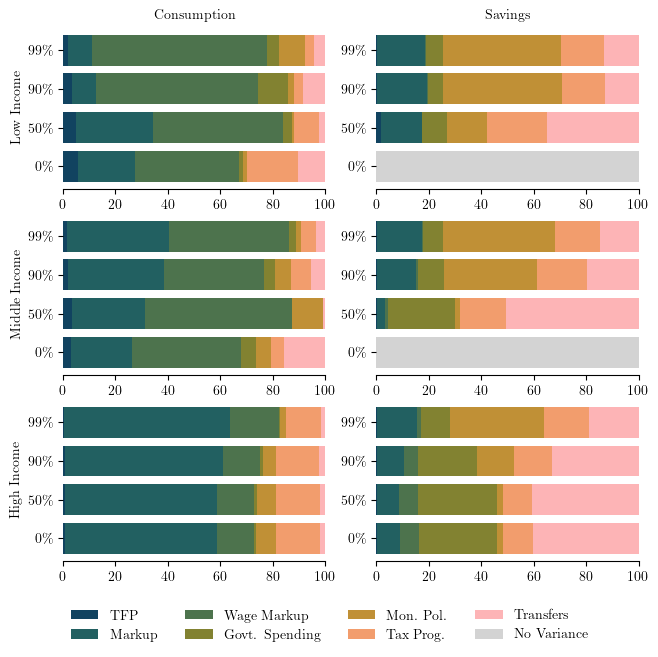

In [9]:
## get variences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas, dxs=dxs), h=4)
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
vars = {x: {Z: var[pts_a][:, pts_z].T for Z, var in vars[x].items()} for x in ['c', 'a']}
# vars[x][Z][i][j] points to effect of Z on x at income i at asset grid j
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending', 'L': 'Labor',  # econ aggs
    }

## plot formatting
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(6.5)
fig.set_figheight(6.5)

# titles
axs[0, 0].set_ylabel('Low Income')
axs[1, 0].set_ylabel('Middle Income')
axs[2, 0].set_ylabel('High Income')
axs[0, 0].set_title('Consumption')
axs[0, 1].set_title('Savings')

for i, x in enumerate(['c', 'a']):  # column, variable of interest
    # solve for varience
    var = np.array(list(vars[x].values()))  # get the variences into an array, use array operations to solve for percents
    total = var.sum(axis=0)
    total =  np.where(total != 0, total, 1)
    pct_var = 100 * var / total  # percent
    left_var = pct_var.cumsum(axis=0) - pct_var  # left side of bar

    for j in range(3):  # row, productivity level
        # formatting
        ax = axs[j, i]
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 100)

        # plot each shock effect
        for k, s in enumerate(hank.shocks):
            ax.barh([r'0\%', r'50\%', r'90\%', r'99\%'], pct_var[k, j], left=left_var[k, j], label=labels[s])
        # gray bar (for no data)
        ax.barh([r'0\%', r'50\%', r'90\%', r'99\%'], 100, left=left_var[-1, j] + pct_var[-1, j], color='lightgray', label='No Variance')

# final things
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=1/7)
fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/policy_var_decomp.pgf')

#### Endogenous Effects Decomposition

In [13]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

## setup
h = 4
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
def get_var_covs(decomp_arr):
    # solve covs
    covs = (decomp_arr[None, :] * decomp_arr[:, None]).sum(axis=-1)  # get covariences between varibales

    # return
    i, j = np.triu_indices(covs.shape[0], 1)
    return np.hstack((np.diag(covs), covs[i, j], covs.sum()))

## lop over variables
for aggx, x in zip(['curlC', 'curlB'], ['c', 'a']):
    ## decompose irfs
    agg_decomp = {}
    policy_decomp = {}
    keys = {'L': 'L', 'W': 'W', 'R': 'R', 'D': 'T', 'epseta': 'T', 'epstauP': r'\tau', 'tauL': r'\tau'}
    for Z, Xirf in irf_decomp.items():
        ## agregates
        for X, irf in Xirf[aggx].items():
            if keys[X] in agg_decomp:
                agg_decomp[keys[X]] += irf[:h]
            else:
                agg_decomp[keys[X]] = 1 * irf[:h]
        
        ## households
        for X, irf in Xirf[x].items():
            if keys[X] in policy_decomp:
                policy_decomp[keys[X]] += irf[:h, pts_a][:, :, pts_z]
            else:
                policy_decomp[keys[X]] = 1 * irf[:h, pts_a][:, :, pts_z]

    ## arrays of decompositions (matrix multiplication is nice)
    agg_decomp_arr = np.array(list(agg_decomp.values()))
    policy_decomp_arr = np.array(list(policy_decomp.values()))

    ## make results dataframe
    factors = np.array(list(agg_decomp.keys()))
    i, j = np.triu_indices(len(factors), 1)
    res_df = pd.DataFrame(data=[np.hstack((factors, factors[i], x)), np.hstack((factors, factors[j], x))], index=pd.MultiIndex.from_tuples([('V', 'V1'), ('V', 'V2')])).T
    res_df[('agg', 'value')] = get_var_covs(agg_decomp_arr)
    res_df[('agg', 'share')] = res_df[('agg', 'value')] / res_df.loc[15, ('agg', 'value')] * 100
    for i in range(3):
        for j in range(4):
            res_df[(f'{i}, {j}', 'value')] = get_var_covs(policy_decomp_arr[:, :, j, i])
            res_df[(f'{i}, {j}', 'share')] = res_df[(f'{i}, {j}', 'value')] / res_df.loc[15, (f'{i}, {j}', 'value')] * 100
    res_df = res_df.fillna(0)

    display(res_df)
    ## make the table
    table = r'''\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components $\times 100$} \\
'''
    for i in res_df[res_df[('V', 'V1')] == res_df[('V', 'V2')]].index[:-1]:
        table += '    \\quad $\\Var(' + res_df.loc[i, ('V', 'V1')] + ')$'
        for v in res_df.values[i, 2::2].astype(float):
            table += f' & {v:,.2f}'
        table += ' \\\\\n   '
        for v in res_df.values[i, 3::2].astype(float):
            table += f' & ({v:,.1f})'
        table += ' \\\\\n'
    table += '    \\cmidrule{2-2} \\cmidrule(lr){3-6} \\cmidrule(lr){7-10} \\cmidrule(lr){11-14}\n    \\emph{Covariance Components $\\times 100$} \\\\\n'
    for i in res_df[res_df[('V', 'V1')] != res_df[('V', 'V2')]].index:
        table += '    \\quad $\\Cov(' + res_df.loc[i, ('V', 'V1')] + ', ' + res_df.loc[i, ('V', 'V2')] + ')$'
        for v in res_df.values[i, 2::2].astype(float):
            table += f' & {v:,.2f}'
        table += ' \\\\\n   '
        for v in res_df.values[i, 3::2].astype(float):
            table += f' & ({v:,.1f})'
        table += ' \\\\\n'
    table += '    \\cmidrule{2-2} \\cmidrule(lr){3-6} \\cmidrule(lr){7-10} \\cmidrule(lr){11-14}\n    \\textit{Total $\\times 100$} \\\\\n'
    table += '    \\quad $\\Var(' + x + ')$'
    for v in res_df.values[15, 2::2].astype(float):
        table += f' & {v:,.2f}'
    table += ' \\\\\n   '
    for v in res_df.values[15, 3::2].astype(float):
        table += f' & ({v:,.1f})'
    table += ' \\\\\n'
    table += '    \\bottomrule \n    \\multicolumn{14}{c}{\\parbox{\\textwidth}{\\vspace{1ex} \\scriptsize \\textit{Notes:} Forecast error variance decomposition calculated at a 4 quarter time horizon. Variance components presented in the table are multiplied by 100. Variance percent share in parentheses. Column percentiles correspond to the 0th, 50th, 90th, and 99th wealth percentiles.}}\n\\end{tabular}%\n}'

    print(f'{aggx}, {x}:')
    print(table)

V             agg                  0, 0                  0, 1  \
      V1    V2     value       share     value       share     value   
0      L     L  0.575107   72.415065  0.137915  129.651134  0.129193   
1      W     W  0.000078    0.009831  0.002825    2.656028  0.002755   
2      R     R  0.245120   30.864512  0.000000    0.000000  0.018262   
3      T     T  0.094180   11.858740  0.083987   78.954823  0.057648   
4   \tau  \tau  0.004493    0.565728  0.125045  117.552156  0.092465   
5      L     W  0.005310    0.668654 -0.018987  -17.849711 -0.018755   
6      L     R  0.355435   44.754840  0.000000    0.000000  0.046681   
7      L     T -0.231483  -29.147390 -0.105263  -98.955663 -0.085314   
8      L  \tau -0.031027   -3.906726 -0.130508 -122.687745 -0.108296   
9      W     R  0.003483    0.438604  0.000000    0.000000 -0.006717   
10     W     T -0.002195   -0.276389  0.013662   12.843279  0.012342   
11     W  \tau -0.000341   -0.042989  0.017493   16.444368  0.015747   
12     R     T -0.148097  -18.647741  0.000000    0.000000 -0.032163   
13     R  \tau -0.027638   -3.480016  0.000000    0.000000 -0.040533   
14     T  \tau  0.014154    1.782215  0.101905   95.798402  0.072925   
15     c     c  0.794182  100.000000  0.106374  100.000000  0.012155   

                     0, 2              ...      1, 3                  2, 0  \
          share     value       share  ...     value       share     value   
0   1062.865091  0.145869   71.155571  ...  0.467763   41.465184  1.285999   
1     22.667531  0.004332    2.112927  ...  0.040189    3.562565  0.030019   
2    150.240820  0.192413   93.859821  ...  0.331432   29.380012  2.533722   
3    474.264978  0.094309   46.004206  ...  0.149247   13.230136  0.130687   
4    760.705715  0.013104    6.392361  ...  0.002179    0.193166  0.253896   
5   -154.299277  0.024485   11.943689  ...  0.136503   12.100428  0.191614   
6    384.042615  0.150395   73.363010  ...  0.326286   28.923868  1.791474   
7   -701.878941 -0.117256  -57.198117  ... -0.264200  -23.420190 -0.409851   
8   -890.947527 -0.042773  -20.864592  ...  0.030432    2.697683  0.571249   
9    -55.259476  0.023013   11.225819  ...  0.090791    8.048249  0.259597   
10   101.538780 -0.019786   -9.651574  ... -0.077188   -6.842390 -0.061378   
11   129.552814 -0.006828   -3.330781  ...  0.009143    0.810485  0.085507   
12  -264.601388 -0.120080  -58.575409  ... -0.183361  -16.254176 -0.569432   
13  -333.467512 -0.047905  -23.368353  ...  0.017484    1.549863  0.793590   
14   599.947844  0.034223   16.693863  ... -0.017252   -1.529350 -0.182135   
15   100.000000  0.205001  100.000000  ...  1.128087  100.000000  9.174789   

                    2, 1                  2, 2                  2, 3  \
         share     value       share     value       share     value   
0    14.016660  1.281086   13.962768  1.198969   14.480368  1.173457   
1     0.327193  0.031144    0.339447  0.059440    0.717872  0.086532   
2    27.616130  2.541224   27.697233  2.218939   26.798893  1.080874   
3     1.424412  0.131842    1.436971  0.155510    1.878152  0.167180   
4     2.767323  0.252099    2.747674  0.210647    2.544051  0.175257   
5     2.088483  0.195016    2.125516  0.264413    3.193407  0.317065   
6    19.526049  1.790422   19.514106  1.606492   19.402165  1.062932   
7    -4.467144 -0.410872   -4.478167 -0.431740   -5.214271 -0.442892   
8     6.226285  0.568147    6.192327  0.502531    6.069242  0.453463   
9     2.829461  0.265175    2.890182  0.346394    4.183524  0.279198   
10   -0.668986 -0.062856   -0.685073 -0.095436   -1.152608 -0.119802   
11    0.931973  0.086858    0.946684  0.110864    1.338942  0.122409   
12   -6.206488 -0.572695   -6.241897 -0.576978   -6.968359 -0.400014   
13    8.649679  0.791904    8.631092  0.672652    8.123848  0.411249   
14   -1.985171 -0.182291   -1.986817 -0.180963   -2.185558 -0.171129   
15  100.000000  9.175012  100.000000  8.279965  100.000000  5.708258   

        

curlC, c:
\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components $\times 100$} \\
    \quad $\Var(L)$ & 0.58 & 0.14 & 0.13 & 0.15 & 0.18 & 0.70 & 0.52 & 0.45 & 0.47 & 1.29 & 1.28 & 1.20 & 1.17 \\
    & (72.4) & (129.7) & (1,062.9) & (71.2) & (146.0) & (904.8) & (78.2) & (26.0) & (41.5) & (14.0) & (14.0) & (14.5) & (20.6) \\
    \quad $\Var(W)$ & 0.00 & 0.00 & 0.00 & 0.00 & 0.02 & 0.01 & 0.00 & 0.02 & 0.04 & 0.03 & 0.03 & 0.06 & 0.09 \\
    & (0.0) & (2.7) & (22.7) & (2.1) & (14.7) & (18.5) & (0.6) & (1.0) & (3.6) & (0.3) & (0.3) & (0.7) & (1.5) \\
    \quad $\Var(R)$ & 0.25 & 0.00 & 0.02 & 0.19 & 0.10 & 0.

V             agg              0, 0            0, 1              \
      V1    V2     value       share value share     value       share   
0      L     L  0.309490   11.135939   0.0   0.0  0.000218    0.389988   
1      W     W  0.137570    4.949974   0.0   0.0  0.000143    0.256228   
2      R     R  4.930862  177.420205   0.0   0.0  0.024120   43.083429   
3      T     T  0.003687    0.132680   0.0   0.0  0.002969    5.303805   
4   \tau  \tau  0.123825    4.455419   0.0   0.0  0.002454    4.383240   
5      L     W -0.203356   -7.317065   0.0   0.0  0.000114    0.203903   
6      L     R -1.176909  -42.347045   0.0   0.0 -0.001784   -3.185689   
7      L     T  0.019549    0.703395   0.0   0.0 -0.000803   -1.433608   
8      L  \tau  0.192247    6.917351   0.0   0.0 -0.000637   -1.137273   
9      W     R  0.812933   29.250625   0.0   0.0 -0.000087   -0.155715   
10     W     T -0.015951   -0.573958   0.0   0.0 -0.000407   -0.727748   
11     W  \tau -0.130481   -4.694929   0.0   0.0 -0.000112   -0.200609   
12     R     T -0.104777   -3.770050   0.0   0.0  0.006811   12.165306   
13     R  \tau -0.771802  -27.770644   0.0   0.0  0.007555   13.495119   
14     T  \tau  0.015430    0.555211   0.0   0.0  0.002389    4.267971   
15     a     a  2.779200  100.000000   0.0   0.0  0.055985  100.000000   

        0, 2              ...       1, 3                  2, 0               \
       value       share  ...      value       share     value        share   
0   0.000680    0.008533  ...   0.025793    0.038028  0.569711   675.279130   
1   0.014074    0.176709  ...   0.101946    0.150306  0.194991   231.123105   
2   6.994693   87.824814  ...  65.927285   97.201336  2.533722  3003.221267   
3   0.007916    0.099387  ...   0.018522    0.027308  0.013857    16.424829   
4   0.057239    0.718693  ...   0.055817    0.082295  0.876709  1039.163970   
5   0.001894    0.023785  ...  -0.045384   -0.066912 -0.312460  -370.359415   
6   0.057399    0.720699  ...  -0.336185   -0.495661 -1.200959 -1423.496867   
7  -0.002298   -0.028855  ...   0.011549    0.017028  0.051874    61.485945   
8   0.001806    0.022673  ...  -0.037904   -0.055885  0.689629   817.416940   
9   0.227442    2.855746  ...   1.602894    2.363262  0.665103   788.347009   
10 -0.005335   -0.066986  ...  -0.037469   -0.055243 -0.043045   -51.021509   
11  0.026504    0.332785  ...   0.067174    0.099040 -0.409621  -485.523350   
12 -0.181274   -2.276058  ...  -0.912059   -1.344715 -0.113129  -134.092023   
13  0.322222    4.045797  ...   0.552728    0.814927 -1.462043 -1732.960334   
14 -0.003477   -0.043653  ...  -0.017280   -0.025477  0.082340    97.597453   
15  7.964369  100.000000  ...  67.825493  100.000000  0.084367   100.000000   

        2, 1                    2, 2                   2, 3              
       value        share      value       share      value       share  
0   0.573005   631.559634   0.630481   10.231593   0.649598    1.090285  
1   0.197860   218.078406   0.262232    4.255563   0.315974    0.530330  
2   2.610068  2876.785477  11.416739  185.273446  70.279195  117.956594  
3   0.014138    15.583025   0.020365    0.330487   0.023755    0.039870  
4   0.880086   970.020734   0.963502   15.635925   1.044726    1.753468  
5  -0.315873  -348.151816  -0.386214   -6.267573  -0.433080   -0.726881  
6  -1.220856 -1345.612833  -1.905630  -30.924999  -3.126997   -5.248352  
7   0.053213    58.651189   0.080507    1.306493   0.093368    0.156708  
8   0.692925   763.733424   0.760137   12.335671   0.803047    1.347835  
9   0.686016   756.118429   1.499283   24.330701   3.155035    5.295411  
10 -0.044014   -48.511194  -0.065298   -1.059670  -0.078923   -0.132464  
11 -0.413527  -455.783983  -0.500252   -8.118203  -0.572856   -0.961481  
12 -0.120994  -133.358592  -0.438536   -7.116670  -1.068273   -1.792990  
13 -1.493122 -1645.700658  -2.728439  -44.277727  -5.276261   -8.855676  
14  0.084017    92.602396   0.118834    1.928469   0.138594    0.23

curlB, a:
\resizebox{\textwidth}{!}{%
\begin{tabular}{@{}w{l}{6em}*{13}{w{c}{3em}}@{}}
    \toprule
    & \textbf{Total} & \multicolumn{4}{c}{\textbf{Low Income}} & \multicolumn{4}{c}{\textbf{Middle Income}} & \multicolumn{4}{c}{\textbf{High Income}} \\
    && 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th & 0th & 50th & 90th & 99th \\
    \cmidrule{2-2} \cmidrule(lr){3-6} \cmidrule(lr){7-10} \cmidrule(lr){11-14}
    \emph{Variance Components $\times 100$} \\
    \quad $\Var(L)$ & 0.31 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.03 & 0.03 & 0.57 & 0.57 & 0.63 & 0.65 \\
    & (11.1) & (0.0) & (0.4) & (0.0) & (0.0) & (0.0) & (4.1) & (0.3) & (0.0) & (675.3) & (631.6) & (10.2) & (1.1) \\
    \quad $\Var(W)$ & 0.14 & 0.00 & 0.00 & 0.01 & 0.04 & 0.00 & 0.01 & 0.06 & 0.10 & 0.19 & 0.20 & 0.26 & 0.32 \\
    & (4.9) & (0.0) & (0.3) & (0.2) & (0.1) & (0.0) & (1.5) & (0.7) & (0.2) & (231.1) & (218.1) & (4.3) & (0.5) \\
    \quad $\Var(R)$ & 4.93 & 0.00 & 0.02 & 6.99 & 62.84 & 0.00 & 0.26 &

#### Decision Rule IRFs

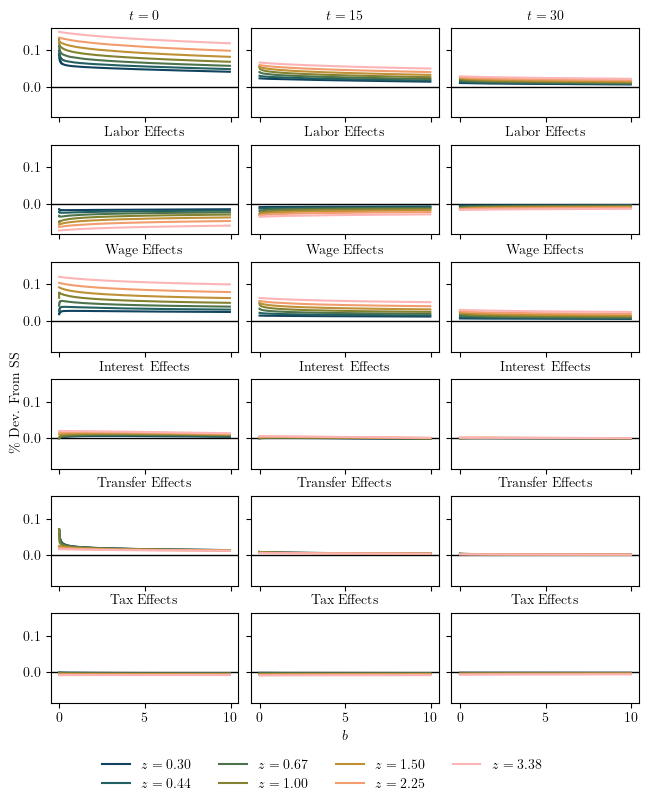

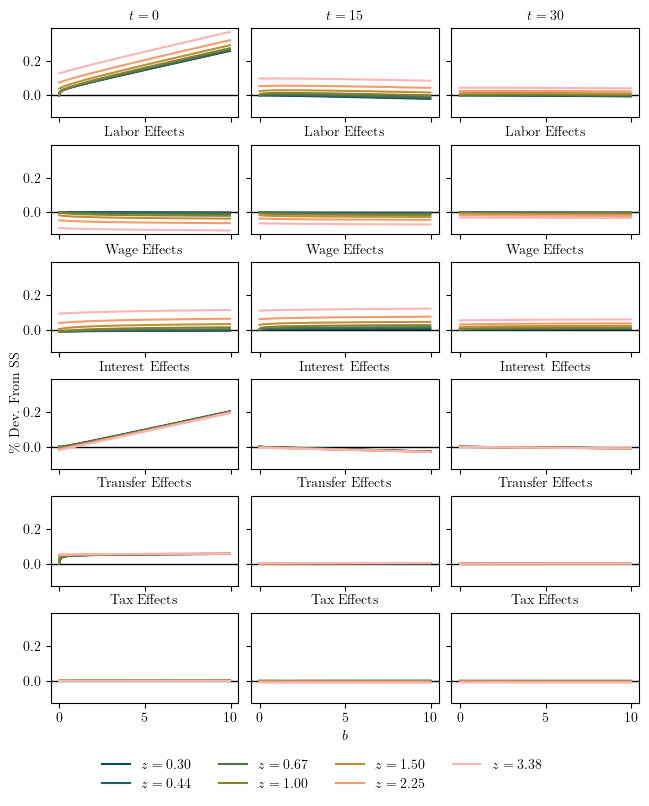

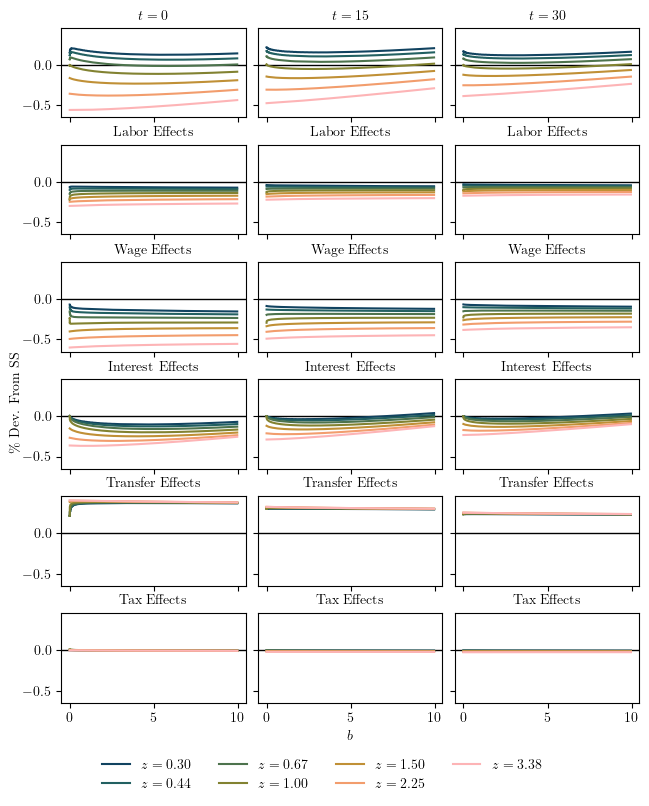

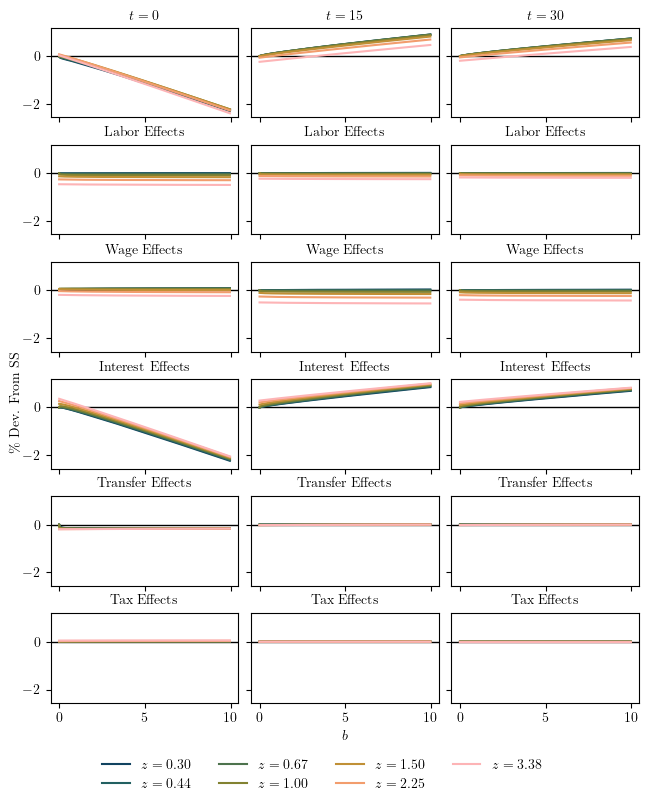

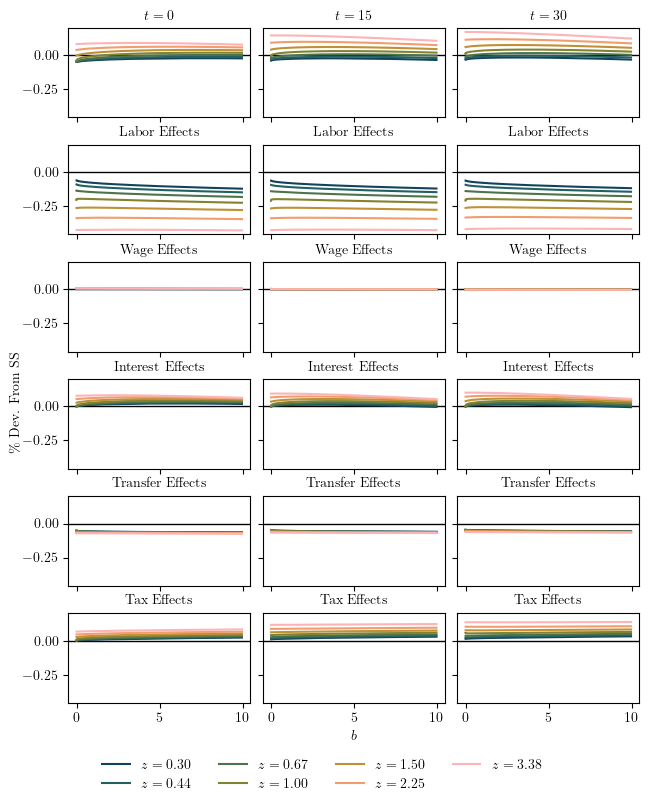

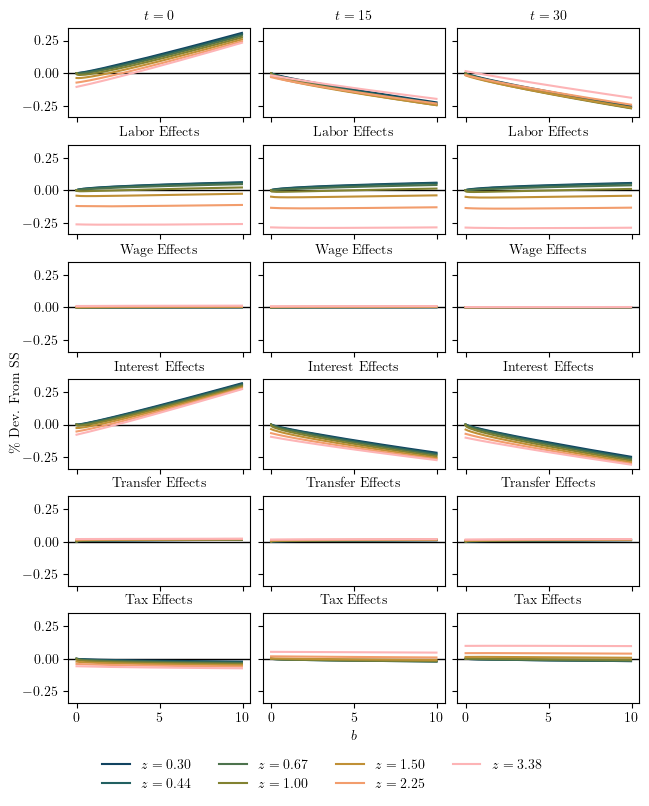

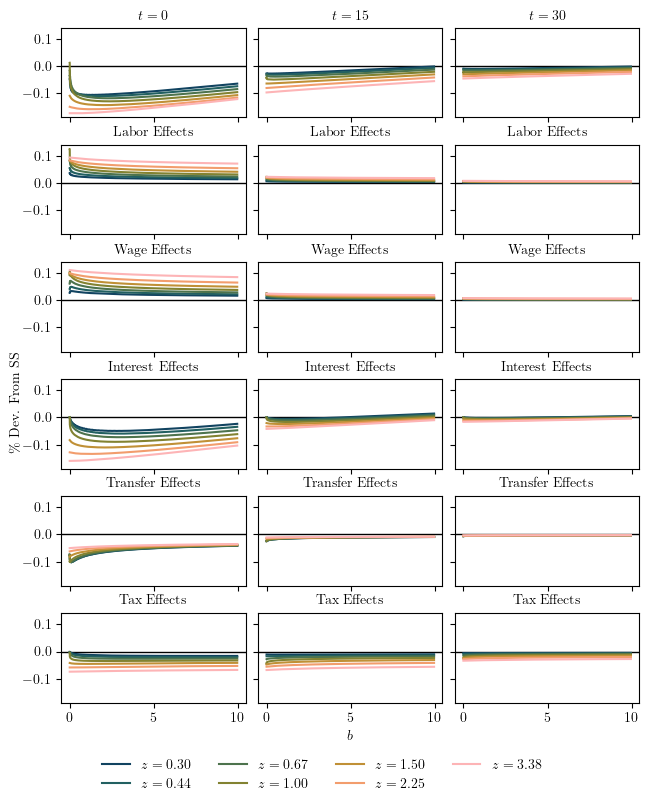

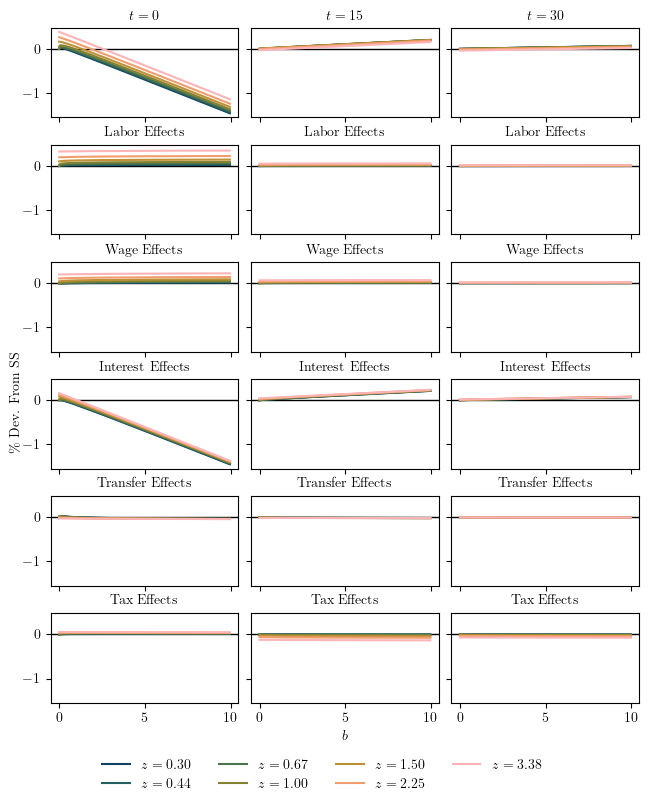

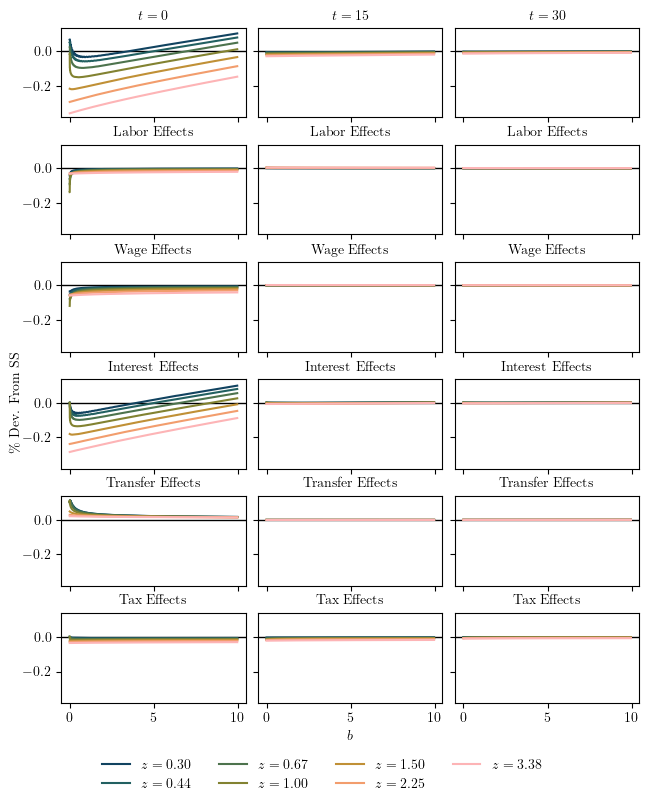

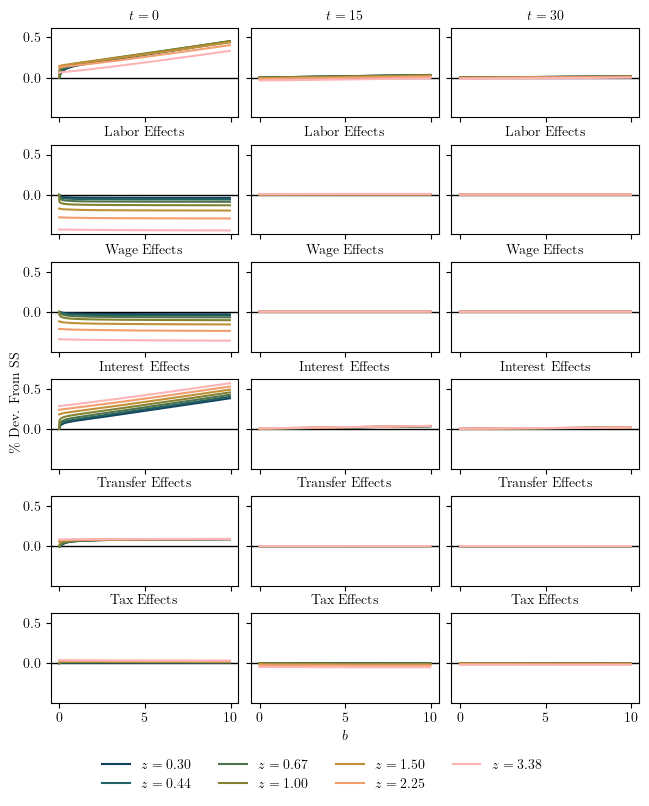

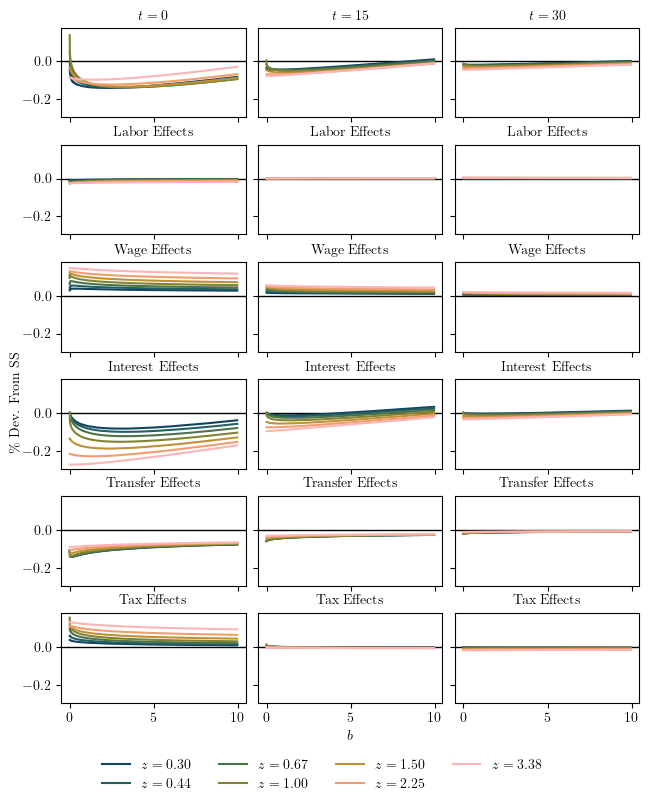

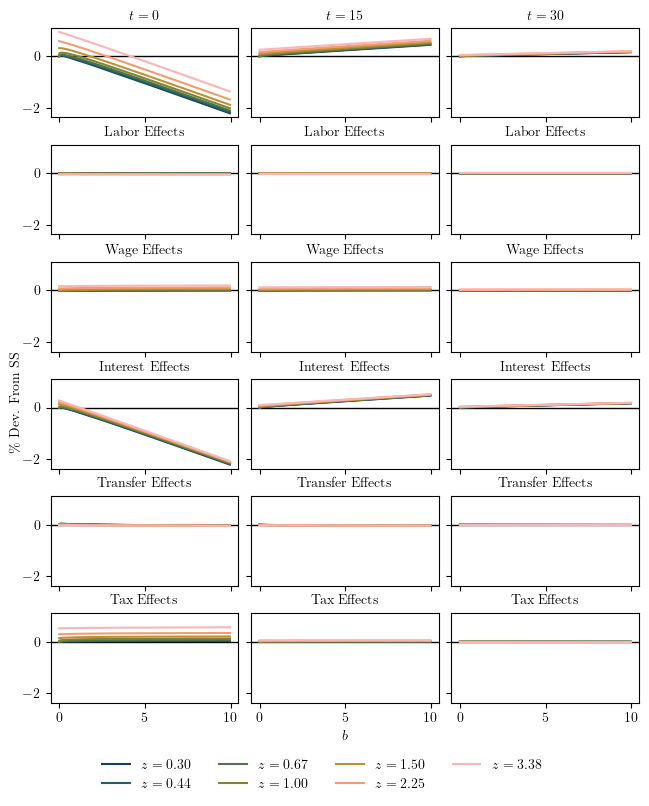

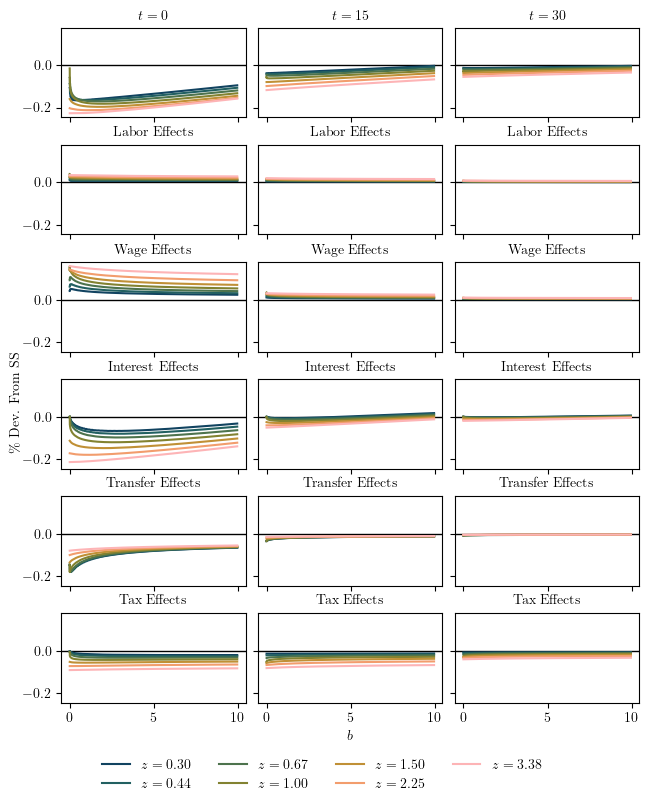

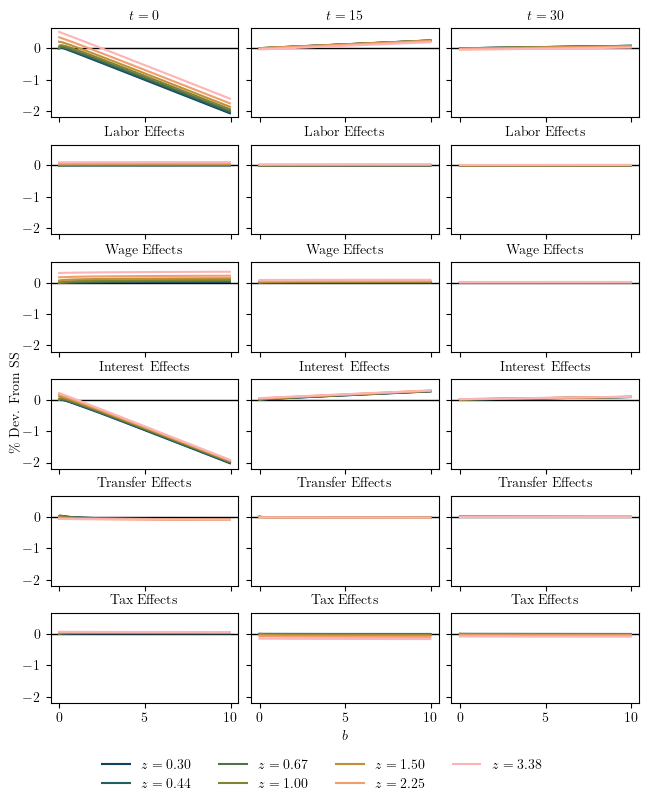

In [11]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

for Z in irf_decomp.keys():
    for x in ['c', 'a']:
        ## plot policy rule irfs
        fig, axs = plt.subplots(6, 3, sharey=True, sharex=True)
        fig.set_figheight(8)
        fig.set_figwidth(6.5)
        axs[-1, 1].set_xlabel('$b$')
        fig.supylabel(r'\% Dev. From SS')
        n = (hank.a_grid < 10).sum()
        for ax in axs.ravel():
            ax.axhline(0, c='k', lw=1)

        ## plot irf at t
        for i, t in enumerate([0, 15, 30]):
            # formating
            axs[0, i].set_title(f'$t = {t}$')

            # decomposition
            axs[1, i].set_title('Labor Effects')
            L_irf = irf_decomp[Z][x]['L'][t, :n]
            axs[1, i].plot(hank.a_grid[:n], L_irf)
            axs[2, i].set_title('Wage Effects')
            W_irf = irf_decomp[Z][x]['W'][t, :n]
            axs[2, i].plot(hank.a_grid[:n], W_irf)
            axs[3, i].set_title('Interest Effects')
            R_irf = irf_decomp[Z][x]['R'][t, :n]
            axs[3, i].plot(hank.a_grid[:n], R_irf)
            axs[4, i].set_title('Transfer Effects')
            T_irf = irf_decomp[Z][x]['D'][t, :n] + irf_decomp[Z][x].get('eta', np.zeros(T)[:, None])[t, :n]
            axs[4, i].plot(hank.a_grid[:n], T_irf)
            axs[5, i].set_title('Tax Effects')
            tau_irf = irf_decomp[Z][x]['tauL'][t, :n] + irf_decomp[Z][x].get('tauP', np.zeros(T)[:, None])[t, :n]
            axs[5, i].plot(hank.a_grid[:n], tau_irf)

            # whole thing
            lns = axs[0, i].plot(hank.a_grid[:n], W_irf + R_irf + T_irf + tau_irf, label=[f'$z = {z:.2f}$' for z in hank.z_grid])

        # fig.legend(handles=lns)
        fig.tight_layout(pad=0.5)
        fig.subplots_adjust(bottom=1/8)
        fig.legend(handles=lns, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
        if save: fig.savefig(f'paper/figures/{x}_{Z[3:]}_irf.pgf')